In [6]:
"""
================================================================================
Titanic 생존 예측 딥러닝 모델 훈련
================================================================================
요구사항 1: Titanic 딥러닝 모델 기본 훈련 및 Wandb 연동
요구사항 2: Activation Function과 Batch Size 변경 및 선택
요구사항 3: 테스트 및 submission.csv 생성
요구사항 4: submission.csv 제출 및 등수 확인
================================================================================
"""

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from datetime import datetime
import wandb
import argparse
import pandas as pd
from pathlib import Path

# ============================================================================
# 경로 설정
# ============================================================================
BASE_PATH = r"C:\Users\p1s7k\git\link_dl"
print("BASE_PATH:", BASE_PATH)

import sys
sys.path.append(BASE_PATH)
sys.path.append(r"C:\Users\p1s7k\git\link_dl\_03_homeworks\homework_2")

from titanic_dataset import get_preprocessed_dataset


# ============================================================================
# 요구사항 1: 데이터 로드 및 DataLoader 구성
# ============================================================================
def get_data():
  """
  Titanic 데이터셋을 로드하고 Train/Validation/Test DataLoader를 생성
  
  Returns:
    train_data_loader: 훈련 데이터 로더 (배치 단위, 셔플 적용)
    validation_data_loader: 검증 데이터 로더 (전체 데이터)
    test_data_loader: 테스트 데이터 로더 (전체 데이터)
  """
  # titanic_dataset.py에서 전처리된 데이터셋 가져오기
  train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()
  print(f"데이터 로드 완료 - Train: {len(train_dataset)}, Validation: {len(validation_dataset)}, Test: {len(test_dataset)}")

  # Train DataLoader: batch_size 적용, 매 epoch마다 셔플
  train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)
  
  # Validation DataLoader: 전체 데이터를 한번에 처리
  validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))
  
  # Test DataLoader: 전체 데이터를 한번에 처리
  test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))

  return train_data_loader, validation_data_loader, test_data_loader


# ============================================================================
# 요구사항 1 & 2: 신경망 모델 정의 (Activation Function 변경 가능)
# ============================================================================
class MyModel(nn.Module):
  """
  Titanic 생존 예측을 위한 3-layer 신경망
  
  구조:
    - Input Layer: 10개 특성 (Pclass, Sex, Age, Fare, etc.)
    - Hidden Layer 1: n_hidden_unit_list[0] 뉴런
    - Hidden Layer 2: n_hidden_unit_list[1] 뉴런
    - Output Layer: 2개 클래스 (생존=1, 사망=0)
  
  Args:
    n_input: 입력 특성 개수 (10)
    n_output: 출력 클래스 개수 (2)
  """
  def __init__(self, n_input, n_output):
    super().__init__()
    
    # 요구사항 2: Activation Function 선택
    # wandb.config.activation 값에 따라 활성화 함수 결정
    if wandb.config.activation == 'relu':
      activation = nn.ReLU()  # 가장 일반적, 기울기 소실 문제 해결
    elif wandb.config.activation == 'sigmoid':
      activation = nn.Sigmoid()  # 0~1 출력, 기울기 소실 문제 있음
    elif wandb.config.activation == 'elu':
      activation = nn.ELU()  # ReLU 개선 버전, 음수 값도 학습
    elif wandb.config.activation == 'leaky_relu':
      activation = nn.LeakyReLU()  # ReLU 개선, 음수에서도 작은 기울기 유지

    # 신경망 구조 정의
    self.model = nn.Sequential(
      nn.Linear(n_input, wandb.config.n_hidden_unit_list[0]),  # 입력층 → 은닉층 1
      activation,                                               # 활성화 함수
      nn.Linear(wandb.config.n_hidden_unit_list[0], wandb.config.n_hidden_unit_list[1]),  # 은닉층 1 → 은닉층 2
      activation,                                               # 활성화 함수
      nn.Linear(wandb.config.n_hidden_unit_list[1], n_output), # 은닉층 2 → 출력층
    )

  def forward(self, x):
    """순전파: 입력 데이터를 모델에 통과시켜 예측값 출력"""
    x = self.model(x)
    return x


# ============================================================================
# 요구사항 1: 모델 및 옵티마이저 초기화
# ============================================================================
def get_model_and_optimizer():
  """
  모델과 옵티마이저를 생성
  
  Returns:
    my_model: 신경망 모델 인스턴스
    optimizer: SGD 옵티마이저 (학습률 적용)
  """
  # 모델 생성: 입력 10개, 출력 2개 (이진 분류)
  my_model = MyModel(n_input=10, n_output=2)
  
  # 옵티마이저: Stochastic Gradient Descent
  optimizer = optim.SGD(my_model.parameters(), lr=wandb.config.learning_rate)
  
  return my_model, optimizer


# ============================================================================
# 요구사항 3: 테스트 데이터로 submission.csv 생성
# ============================================================================
def generate_submission(model, test_data_loader, epoch):
  """
  훈련된 모델로 테스트 데이터를 예측하고 Kaggle 제출용 CSV 파일 생성
  
  Args:
    model: 훈련된 신경망 모델
    test_data_loader: 테스트 데이터 로더
    epoch: 현재 epoch (파일명에 포함)
  """
  model.eval()  # 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
  predictions = []
  
  # 테스트 데이터 예측 (기울기 계산 불필요)
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_data = test_batch['input']
      output = model(input_data)  # 모델 예측
      _, predicted = torch.max(output, 1)  # 가장 높은 확률의 클래스 선택
      predictions.extend(predicted.cpu().numpy())
  
  # test.csv에서 PassengerId 가져오기
  test_csv_path = r"C:\Users\p1s7k\git\link_dl\_03_homeworks\homework_2\test.csv"
  
  try:
    test_df = pd.read_csv(test_csv_path)
  except FileNotFoundError:
    print(f"test.csv를 찾을 수 없습니다: {test_csv_path}")
    print("submission.csv 생성 실패")
    return
  
  # Kaggle 제출 형식: PassengerId, Survived
  submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': predictions
  })
  
  # 파일명: 실험 조건 포함 (epoch, activation, batch_size)
  filename = f'submission_ep{epoch}_act{wandb.config.activation}_bs{wandb.config.batch_size}.csv'
  submission.to_csv(filename, index=False)
  print(f"✓ Submission 생성: {filename}")
  print(f"  저장 위치: {Path(filename).absolute()}")


# ============================================================================
# 요구사항 1, 2, 3: 모델 훈련 루프
# ============================================================================
def training_loop(model, optimizer, train_data_loader, validation_data_loader, test_data_loader):
  """
  모델 훈련 및 검증을 수행하고 최적 모델로 submission 생성
  
  훈련 과정:
    1. 매 epoch마다 Train 데이터로 학습
    2. Validation 데이터로 성능 평가
    3. Validation Loss가 최소인 epoch의 모델 저장
    4. 최적 모델로 테스트 데이터 예측 및 submission.csv 생성
  
  Args:
    model: 신경망 모델
    optimizer: 옵티마이저
    train_data_loader: 훈련 데이터 로더
    validation_data_loader: 검증 데이터 로더
    test_data_loader: 테스트 데이터 로더
  
  Returns:
    best_epoch: 최적 성능을 보인 epoch 번호
  """
  n_epochs = wandb.config.epochs
  loss_fn = nn.CrossEntropyLoss()  # 분류 문제용 손실 함수
  next_print_epoch = 100  # 100 epoch마다 출력
  
  # 요구사항 3: Best 모델 추적 변수 (Validation Loss 최소값)
  best_val_loss = float('inf')  # 무한대로 초기화
  best_epoch = 0  # 최적 epoch
  best_model_state = None  # 최적 모델의 가중치 저장
  
  # ========== 훈련 시작 ==========
  for epoch in range(1, n_epochs + 1):
    # ---------- Training Phase ----------
    model.train()  # 훈련 모드
    loss_train = 0.0
    num_trains = 0
    correct_train = 0
    total_train = 0
    
    for train_batch in train_data_loader:
      input_data, target = train_batch['input'], train_batch['target']
      
      # 순전파: 예측값 계산
      output_train = model(input_data)
      loss = loss_fn(output_train, target)
      loss_train += loss.item()
      num_trains += 1
      
      # 정확도 계산
      _, predicted = torch.max(output_train, 1)
      total_train += target.size(0)
      correct_train += (predicted == target).sum().item()

      # 역전파: 기울기 계산 및 가중치 업데이트
      optimizer.zero_grad()  # 기울기 초기화
      loss.backward()  # 기울기 계산
      optimizer.step()  # 가중치 업데이트

    # ---------- Validation Phase ----------
    model.eval()  # 평가 모드
    loss_validation = 0.0
    num_validations = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():  # 기울기 계산 비활성화
      for validation_batch in validation_data_loader:
        input_data, target = validation_batch['input'], validation_batch['target']
        
        # 순전파: 예측값 계산
        output_validation = model(input_data)
        loss = loss_fn(output_validation, target)
        loss_validation += loss.item()
        num_validations += 1
        
        # 정확도 계산
        _, predicted = torch.max(output_validation, 1)
        total_val += target.size(0)
        correct_val += (predicted == target).sum().item()

    # 평균 손실 및 정확도 계산
    avg_train_loss = loss_train / num_trains
    avg_val_loss = loss_validation / num_validations
    train_acc = 100 * correct_train / total_train
    val_acc = 100 * correct_val / total_val

    # ---------- Best 모델 추적 (요구사항 3) ----------
    # Validation Loss가 감소하면 현재 모델을 최적 모델로 저장
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      best_epoch = epoch
      best_model_state = model.state_dict().copy()  # 모델 가중치 복사

    # ---------- Wandb 로깅 (요구사항 1) ----------
    wandb.log({
      "Epoch": epoch,
      "Training loss": avg_train_loss,
      "Validation loss": avg_val_loss,
      "Training accuracy": train_acc,
      "Validation accuracy": val_acc,
      "Best Validation loss": best_val_loss,
      "Best Epoch": best_epoch
    })

    # 100 epoch마다 콘솔 출력
    if epoch >= next_print_epoch:
      print(
        f"Epoch {epoch}, "
        f"Training loss {avg_train_loss:.4f}, "
        f"Validation loss {avg_val_loss:.4f}, "
        f"Train acc {train_acc:.2f}%, "
        f"Val acc {val_acc:.2f}%, "
        f"Best Epoch: {best_epoch}"
      )
      next_print_epoch += 100

  # ========== 훈련 종료 ==========
  print(f"\n최적 모델: Epoch {best_epoch}, Validation Loss: {best_val_loss:.4f}")
  
  # 요구사항 3: 최적 모델로 복원 후 submission 생성
  model.load_state_dict(best_model_state)
  generate_submission(model, test_data_loader, best_epoch)
  
  return best_epoch


# ============================================================================
# 요구사항 1: 메인 실행 함수
# ============================================================================
def main(args):
  """
  전체 훈련 프로세스 실행
  
  Args:
    args: 실행 인자 (wandb 활성화 여부, batch_size, epochs, activation)
  """
  current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  # Wandb 설정
  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,  # 요구사항 2: 16, 32, 64, 128
    'learning_rate': 1e-3,
    'n_hidden_unit_list': [64, 32],  # 은닉층 뉴런 개수
    'activation': args.activation,  # 요구사항 2: relu, sigmoid, elu, leaky_relu
  }

  # Wandb 초기화 (요구사항 1)
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project="titanic_survival_prediction",  # 프로젝트명
    notes="Titanic model training with various configurations",
    tags=["titanic", f"act_{args.activation}", f"bs_{args.batch_size}"],
    name=f"{current_time_str}_act{args.activation}_bs{args.batch_size}",
    config=config
  )
  print("실행 설정:")
  print(args)
  print(wandb.config)

  # 데이터 로드
  train_data_loader, validation_data_loader, test_data_loader = get_data()
  
  # 모델 및 옵티마이저 생성
  linear_model, optimizer = get_model_and_optimizer()

  print("#" * 50, 1)

  # 훈련 실행
  training_loop(
    model=linear_model,
    optimizer=optimizer,
    train_data_loader=train_data_loader,
    validation_data_loader=validation_data_loader,
    test_data_loader=test_data_loader
  )
  
  # Wandb URL 출력 (요구사항 1)
  print(f"\n📊 Wandb URL: {wandb.run.get_url()}")
  wandb.finish()



if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 32
        epochs = 1000
        activation = 'relu'

    args = Args()
    main(args)

BASE_PATH: C:\Users\p1s7k\git\link_dl


실행 설정:
{'epochs': 1000, 'batch_size': 32, 'learning_rate': 0.001, 'n_hidden_unit_list': [64, 32], 'activation': 'relu'}


C:\Users\p1s7k\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:128: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\p1s7k\git\link_dl\_03_homeworks\homework_2\titanic_dataset.py:147: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'title', 'family_num', 'alone'],
      dtype='object')
   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked  title  \
0       0.0       3    1  22.0      1      0   7.2500         2      2   
1       1.0       1    0  38.0      1      0  71.2833         0      3   
2       1.0       3    0  26.0      0      0   7.9250         2      1   
3       1.0       1    0  35.0      1      0  53.1000         2      3   
4       0.0       3    1  35.0      0      0   8.0500         2      2   
5       0.0       3    1  29.0      0      0   8.4583         1      2   
6       0.0       1    1  54.0      0      0  51.8625         2      2   
7       0.0       3    1   2.0      3      1  21.0750         2      0   
8       1.0       3    0  27.0      0      2  11.1333         2      3   
9       1.0       2    0  14.0      1      0  30.0708         0      3   

   family_num  alone  
0           1    0.

Best Epoch,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇▇▇████
Best Validation loss,████▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁
Epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█
Training accuracy,▁▁▁▁▁▁▂▁▁▂▂▃▂▃▃▃▃▄▄▄▅▅▆▆▇▆▇▇▇▆▇▆▇▇▆█▇█▇▇
Training loss,█▇▇▇▇▆▇▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▄▄▂▃▂▂▂▂▂▂▂▂▂▂▃▂▁
Validation accuracy,▃▄▄▃▄▄▅▃▅▃▅▅▆▅▅▅▆▆▆▆▆▇▇▇▅▇█▅▁▆▆▁▇▄█▇▆█▇▇
Validation loss,▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▂▁▂▂█▁▁▁▁▁▁
Best Epoch,984
Best Validation loss,0.45456
Epoch,1000
Training accuracy,80.92567


## 1. ReLU Batch Size: 16

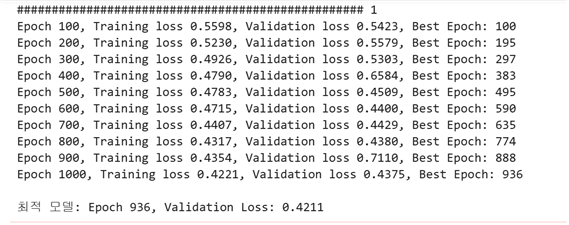

## 2. ReLU Batch Size: 32

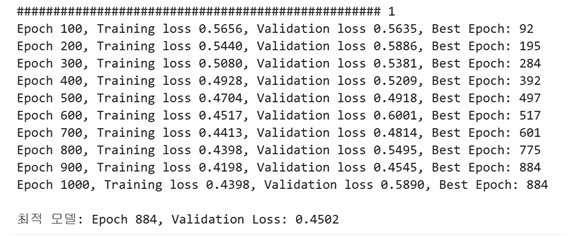

## 3. ReLU Batch Size: 64

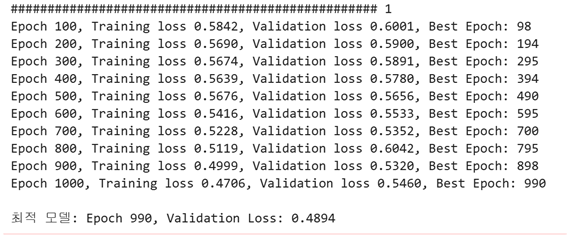

## 4. ReLU Batch Size: 128

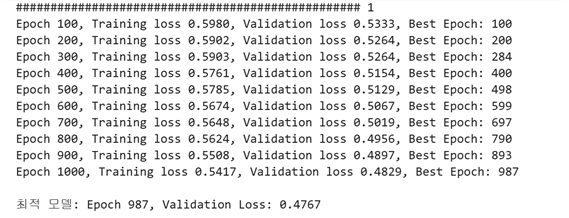

## 5. Sigmoid Batch Size: 16

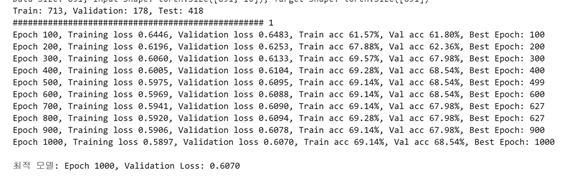

## 6. Sigmoid Batch Size: 32

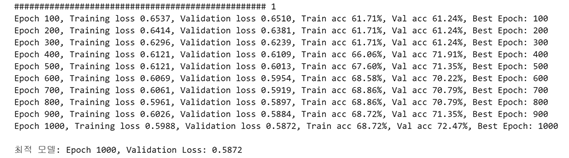

## 7. Sigmoid Batch Size: 64

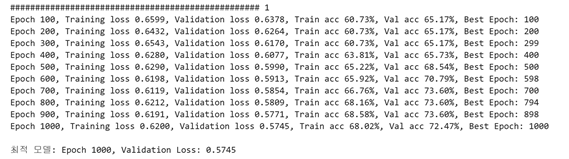

## 8. Sigmoid Batch Size: 128

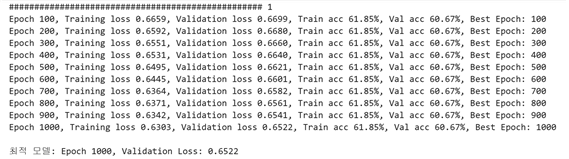

## 9. ELU Batch Size: 16

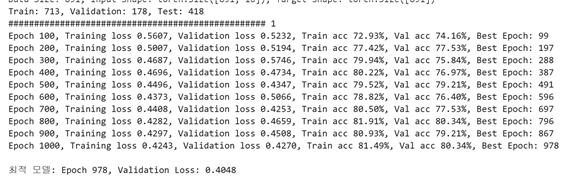

## 10. ELU Batch Size: 32

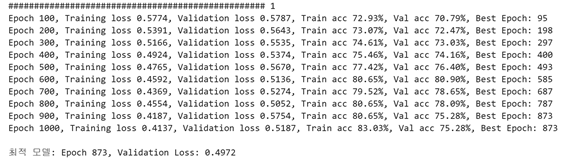

## 11. ELU Batch Size: 64

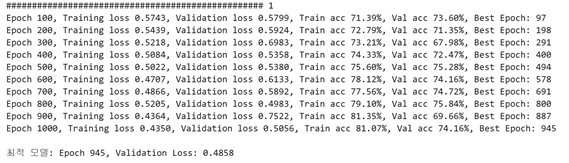

## 12. ELU Batch Size: 128

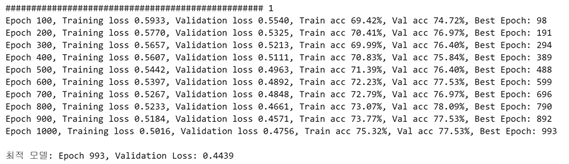

## 13. Leaky_ReLU Batch Size: 16

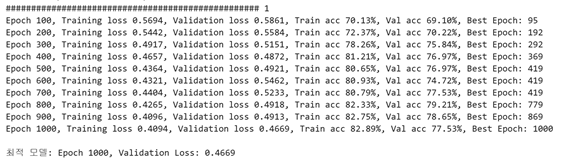

## 14. Leaky_ReLU Batch Size: 32

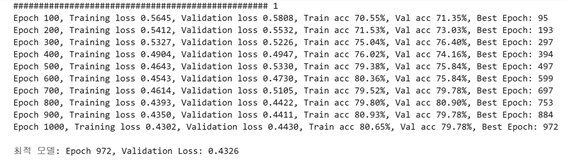

## 15. Leaky_ReLU Batch Size: 64

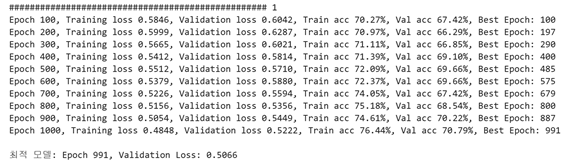

## 16. Leaky_ReLU Batch Size: 128

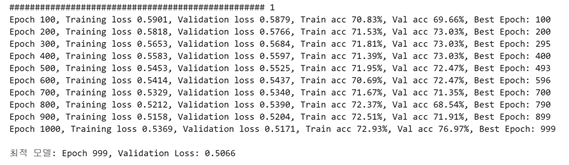

## [요구사항2] Activation Function과 Batch Size 변경 및 선택하기

코드를 돌려봤을 때 ELU 함수로 Batch Size가 16일 때 validation Loss가 0.4048로 가장 낮았고 가장 좋은 성능을 산출하였다.

## [요구사항4] submission.csv 제출 및 등수 확인

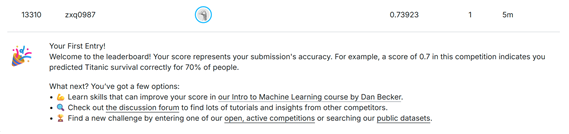

## 숙제 후기

이번 과제를 통해 가장 흥미로웠던 점은 다양한 하이퍼파라미터 조합을 직접 실험하며 최적의 모델을 찾아가는 과정이었습니다. ReLU나 Sigmoid 같은 활성화 함수, 그리고 배치 사이즈 같은 작은 설정값 하나가 모델의 학습 과정과 최종 성능에 어떤 영향을 미치는지 직접 눈으로 확인하는 것이 신기했고 여러 조합으로 실험을 반복하며 조금씩 검증 손실(validation loss)을 낮춰가는 과정이 흥미로웠습니다.

또한, 이렇게 만들어진 최적의 모델을 캐글(Kaggle)에 제출하여 실시간으로 제 성능과 순위를 확인할 수 있다는 점도 재밌었고, 딥러닝 학습에 대한 동기부여가 되었습니다.